In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from time import time
from keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping,CSVLogger,ReduceLROnPlateau,LearningRateScheduler
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
print(os.listdir("./cell_images"))

Using TensorFlow backend.


['.DS_Store', 'Parasitized', 'Uninfected']


In [2]:
infected = os.listdir('./cell_images/Parasitized/') 
uninfected = os.listdir('./cell_images/Uninfected/')

In [3]:
data=[]
labels=[]

#load images
def loadImages(path):
    image_files= os.listdir(path)
    return image_files

#Data Preprocessing
def preprocessing(path):
    image_files=loadImages(path)
    print(len(image_files))
    for i in image_files:
        try:
            image = cv2.imread(path +i)
            image_array = Image.fromarray(image , 'RGB')
            resize_img = image_array.resize((50 , 50))
            rotated45 = resize_img.rotate(45)
            rotated75 = resize_img.rotate(75)
            blur = cv2.blur(np.array(resize_img) ,(10,10))
            #Uncomment to do segmentation
            #gray_img= cv2.cvtColor(blur,cv2.COLOR_RGB2GRAY)
            #ret, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            #Append labels 0 for uninfected; 1 for infected
            if "Uninfected" in path:
                labels.append(0)
            else: 
                labels.append(1)
            data.append(np.array(rotated75))
        except AttributeError:
            print('aa')   
    return data

# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()
    
# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [4]:
image_path_uninfected="./cell_images/Uninfected/"
image_path_parasitized="./cell_images/Parasitized/"
imageArrayUninfected= preprocessing(image_path_uninfected)
imageArrayTotal= preprocessing(image_path_parasitized)

13780
aa
13780
aa


In [5]:
len(imageArrayTotal)

27558

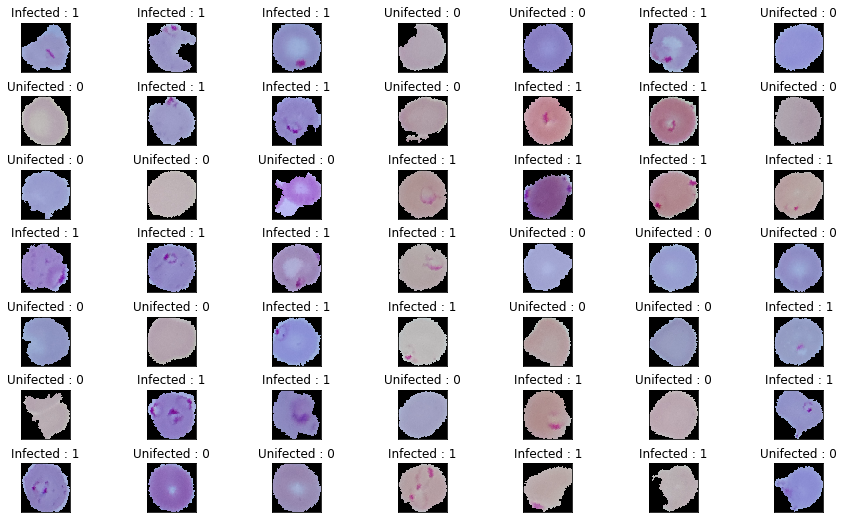

In [5]:
#Convert to np array
cells = np.array(data)
labels = np.array(labels)
np.save('Cells' , cells)
np.save('Labels' , labels)

plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint(0 , cells.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(cells[r[0]])
    plt.title('{} : {}'.format('Infected' if labels[r[0]] == 1 else 'Unifected' ,
                               labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])
    
plt.show()

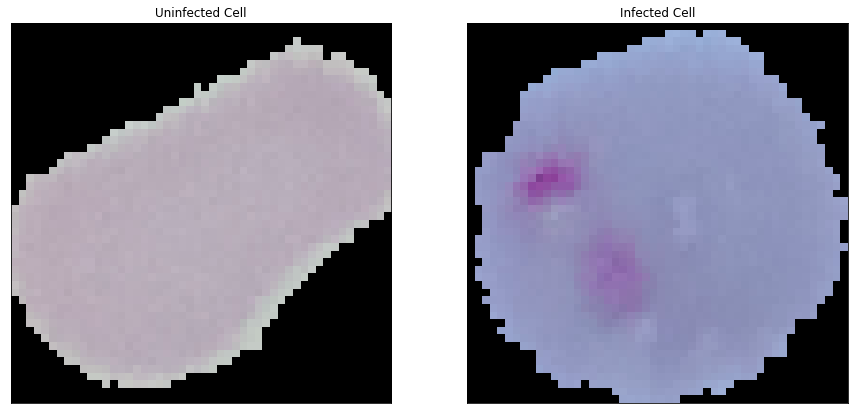

In [6]:
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(cells[1])
plt.title('Uninfected Cell')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(cells[26000])
plt.title('Infected Cell')
plt.xticks([]) , plt.yticks([])

plt.show()

In [7]:
#Shuffle the dataset
n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]

cells = cells.astype(np.float32)
labels = labels.astype(np.int32)
cells = cells/255

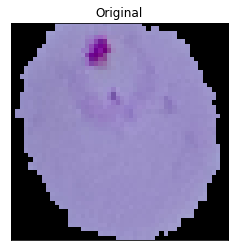

In [56]:
display_one(cells[10])

In [8]:
from sklearn.model_selection import train_test_split

x_train , x , y_train , y = train_test_split(cells , labels , 
                                            test_size = 0.2 ,
                                            random_state = 111)

x_eval , x_test , y_eval , y_test = train_test_split(x , y , 
                                                    test_size = 0.5 , 
                                                    random_state = 111)

In [9]:
num_classes=len(np.unique(labels))
len_data=len(cells)

In [10]:
#Doing One hot encoding as classifier has multiple classes
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

In [14]:
y_train[1000]

array([1., 0.], dtype=float32)

In [11]:
#creating sequential model
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(500,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxP

In [12]:
# compile the model with loss as categorical_crossentropy and using adam optimizer you can test result by trying RMSProp as well as Momentum
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
#-------Callbacks-------------#
best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

#lrsched = LearningRateScheduler(step_decay,verbose=1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=40,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [14]:
#Fit the model with min batch size as 50[can tune batch size to some factor of 2^power ] 
model.fit(x_train,y_train,batch_size=50,epochs=5,verbose=1, callbacks=[checkpoint,tensorboard,csvlogger,reduce])

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
22046/22046 [==============================] - 78s 4ms/step - loss: 0.5666 - acc: 0.6883
Epoch 2/5


/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


22046/22046 [==============================] - 75s 3ms/step - loss: 0.2051 - acc: 0.9278
Epoch 3/5
22046/22046 [==============================] - 80s 4ms/step - loss: 0.1556 - acc: 0.9487
Epoch 4/5
22046/22046 [==============================] - 73s 3ms/step - loss: 0.1392 - acc: 0.9551
Epoch 5/5
22046/22046 [==============================] - 74s 3ms/step - loss: 0.1272 - acc: 0.9593


In [15]:
accuracy = model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

2756/2756 [==============================] - 3s 1ms/step

 Test_Accuracy:- 0.9564586357039188


In [18]:
y_pred = model.predict(x_test)

In [19]:
#Reverse one hot encoding
from numpy import argmax
y_pred_conv = np.argmax(y_pred, axis=-1)
y_test_conv = np.argmax(y_test, axis=-1)

In [21]:
y_pred_conv

array([1, 0, 0, ..., 0, 0, 0])

In [74]:
import pandas as pd
frame = pd.DataFrame(y_pred_conv,y_test_conv)
frame[:14]

,0
0,0
0,0
0,0
0,0
1,1
0,0
0,0
0,0
1,1
1,1


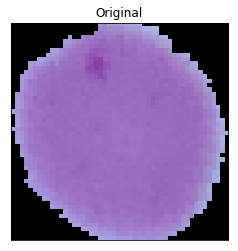

In [83]:
#erroneous result
display_one(x_test[13])

In [78]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[1316   42]
 [  94 1304]]


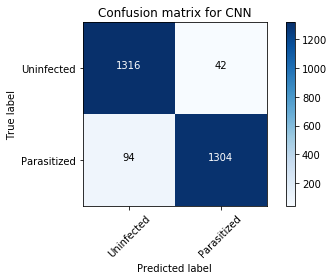

In [81]:
conf_matrix_CNN= confusion_matrix(y_test_conv,y_pred_conv)
plot_confusion_matrix(conf_matrix_CNN, classes= my_tags,
                      title='Confusion matrix for CNN')

In [82]:
# Classification Report for SVM
my_tags = ['Uninfected','Parasitized']
print(metrics.classification_report(y_test_conv, y_pred_conv,target_names=my_tags))

              precision    recall  f1-score   support

  Uninfected       0.93      0.97      0.95      1358
 Parasitized       0.97      0.93      0.95      1398

   micro avg       0.95      0.95      0.95      2756
   macro avg       0.95      0.95      0.95      2756
weighted avg       0.95      0.95      0.95      2756



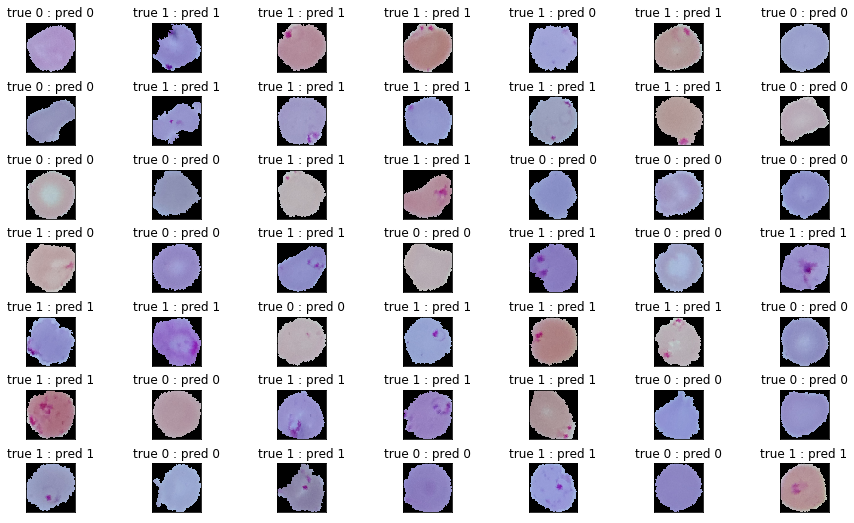

In [88]:
#Visualizing errors
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint( 0  , x_test.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(x_test[r[0]])
    plt.title('true {} : pred {}'.format(y_test_conv[r[0]] , y_pred_conv[r[0]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()
